# Gather insights from the experiments run on GCP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [2]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [5]:
df = join_df('./results/resnet/train')
df = df[df.default_parallelism > 1]

In [6]:
df

,id,hash,model_type,batch_size,epochs,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,validation_loss,accuracy,train_loss,parallelism,epoch_duration
0,0386935d,69979e67b7622197,example,128,30,cifar10,0.1,resnet,4,True,1,8,100,"[2.0691979338851154, 1.761023279986804, 1.5237...","[21.41020569620253, 32.070806962025316, 47.784...","[3.4358344075022913, 1.9820176490715573, 1.680...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[46.101114115, 92.594095861, 138.901519929, 18..."
1,05666e5d,a2cc2a5d5cc402f9,example,128,30,cifar10,0.1,resnet,4,True,1,32,100,"[2.1832512511482722, 1.6482713418670847, 1.520...","[20.352056962025316, 39.47784810126582, 45.203...","[3.633183332122102, 1.9733640703619744, 1.6998...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[19.251981886, 39.583568774, 60.468725951, 79...."
2,06804c15,8b0f4cc587901704,example,256,30,cifar10,0.1,resnet,4,True,1,8,100,"[2.592677044868469, 1.7636539191007614, 1.6012...","[17.958984375, 33.1640625, 39.794921875, 44.40...","[4.071233475694851, 2.1830299715606536, 1.8489...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[26.678817886, 53.53629918, 78.251857194, 103...."
3,0bb3e9ac,50f218a144063794,example,64,30,cifar10,0.1,resnet,2,True,1,8,100,"[2.01867682842692, 1.906603324944806, 1.419383...","[28.54299363057325, 28.61265923566879, 47.2730...","[2.624373005631635, 1.756249717129466, 1.54868...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[102.032926309, 201.191873608, 299.563335538, ..."
4,13190b0b,02b1f56c9c27a5b4,example,128,30,cifar10,0.1,resnet,2,True,1,32,100,"[5.0395004236245455, 1.5423524047754988, 1.449...","[10.116693037974683, 44.11590189873418, 47.567...","[2.962399608322552, 1.6866237937795874, 1.4655...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[23.07288706, 46.800417874, 74.283571081, 98.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,f86d546d,4cf9aff8b0e3ec9e,example,64,30,cifar10,0.1,resnet,4,True,1,-1,100,"[3.8288797876637455, 2.403817397014351, 1.9774...","[10, 10.26, 26.85, 35.03, 40.550000000000004, ...","[3.360841138029304, 2.3875012396939574, 1.9948...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[14.801709896, 31.24002004, 48.253630979, 64.1..."
98,f9dc984a,9c49eeb8a706275a,example,64,30,cifar10,0.1,resnet,2,True,1,32,100,"[1.705808477037272, 1.4686595649476264, 1.3200...","[37.430334394904456, 46.34753184713376, 52.478...","[2.712390104218212, 1.6115226571822105, 1.4244...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[38.899608234, 82.870589755, 126.082686868, 16..."
99,f9ff89fc,7e945a487feff74e,example,128,30,cifar10,0.1,resnet,4,True,1,16,100,"[2.1471189894253695, 1.759268745591369, 1.5828...","[22.34, 33.46, 41.81, 47.64, 48.33999999999999...","[3.2209879354174644, 1.9946543223091535, 1.743...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[27.999510971, 57.792588364, 86.948315407, 115..."
100,fbcccc6c,afe503f94d4d8264,example,64,30,cifar10,0.1,resnet,4,True,1,32,100,"[1.8421584147556571, 1.573136512640935, 1.5360...","[31.22014331210191, 41.49084394904459, 42.8841...","[3.297370414573881, 1.8065422634400665, 1.6034...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[31.308027951, 61.831227029, 90.963939092, 120..."


In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [7]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [9]:
# compute the ttas
df['tta_69'] = tta(69, df)
df['tta_cross_69'] = tta_crossbow(69, df)

### For the metrics in resnet

In [14]:
metrics = join_df('./results/resnet/metrics')
m = metrics.rename(columns={'exp_name':'id'})

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [ ]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [15]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [17]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/resnet_kubeml.pkl')


# TensorFlow Experiments

How to treat the TF experiments

In [ ]:
df = join_df('./results/tf/lenet/train/1/', './results/tf/lenet/train/2', './results/tf/lenet/train/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [23]:
# Define the TTA
resnet['tta_67'] = tta(0.69, resnet, time_column='times', acc_column='val_accuracy')
resnet['tta_cross_67'] = tta_crossbow(0.69, resnet, time_column='times', acc_column='val_accuracy')

## Merge the metrics from different  folders


In [ ]:
m = join_df('./results/tf/lenet/metrics/1/', './results/tf/lenet/metrics/2', './results/tf/lenet/metrics/3')

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [ ]:
df = df.join(m)

Save the experiments

In [24]:
resnet.to_pickle('./dataframes/resnet_tensorflow.pkl')

# Visualization of Results


Set the color palette

In [ ]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette(blue_yellow_palette))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
# sns.set_palette(blue_yellow_palette)

# Read the experiments file

### Load all of the dataframes

In [43]:
# load the tf experiments
resnet = pd.read_pickle('./dataframes/resnet_tensorflow.pkl')
lenet = pd.read_pickle('./dataframes/lenet_tensorflow.pkl')

resnet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
resnet['system'] = 'tensorflow'


# set the columns of the 

# load the kubeml experiments
kuberesnet = pd.read_pickle('./dataframes/resnet_kubeml.pkl')
kuberesnet['model'] = 'resnet'
kuberesnet['system'] = 'kubeml'

kubelenet = pd.read_pickle('./dataframes/lenet_kubeml.pkl')

In [45]:
# save the full resnet stuff
r.to_pickle('./dataframes/resnet.pkl')

In [44]:
r = pd.concat([resnet, kuberesnet], ignore_index=True)
r
# resnet

,model,hash,batch_size,epochs,train_accuracy,train_loss,accuracy,validation_loss,epoch_duration,acc,...,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,parallelism,global_batch
0,resnet,3b64b0be38fb8e94,32,30,"[0.17032000422477722, 0.2808600068092346, 0.35...","[2.386634588241577, 1.8890058994293213, 1.7486...","[0.2615000009536743, 0.3276999890804291, 0.395...","[1.8862396478652954, 1.725894570350647, 1.6532...","[86.82871699333191, 161.10458970069885, 235.44...",0.654200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,resnet,9848e15a8cb9456b,256,30,"[0.20927999913692474, 0.35989999771118164, 0.4...","[2.9395194053649902, 1.7702909708023071, 1.570...","[0.14980000257492065, 0.17270000278949738, 0.3...","[2.747114896774292, 2.5870492458343506, 1.9928...","[26.537360668182373, 38.13520431518555, 49.665...",0.656100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,resnet,e551b774a7b5ccc0,128,30,"[0.21724000573158264, 0.33597999811172485, 0.4...","[2.6788625717163086, 1.7895755767822266, 1.611...","[0.23649999499320984, 0.2770000100135803, 0.44...","[2.0208323001861572, 1.976898431777954, 1.5212...","[33.218318939208984, 53.329391956329346, 73.47...",0.653100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,resnet,eeaea0a56be5c6c9,64,30,"[0.21930000185966492, 0.346560001373291, 0.435...","[2.442678451538086, 1.7620742321014404, 1.5449...","[0.20569999516010284, 0.38609999418258667, 0.4...","[2.4119229316711426, 1.6152931451797485, 1.422...","[51.08732867240906, 89.5283989906311, 127.9574...",0.658100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,resnet,3b64b0be38fb8e94,32,30,"[0.17776000499725342, 0.25637999176979065, 0.3...","[2.443981170654297, 1.9975420236587524, 1.8435...","[0.2281000018119812, 0.31769999861717224, 0.39...","[2.1482324600219727, 1.9316531419754028, 1.673...","[91.24218130111694, 167.12129759788513, 242.37...",0.682500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,resnet,4cf9aff8b0e3ec9e,64,30,NaN,"[3.360841138029304, 2.3875012396939574, 1.9948...","[10, 10.26, 26.85, 35.03, 40.550000000000004, ...","[3.8288797876637455, 2.403817397014351, 1.9774...","[14.801709896, 31.24002004, 48.253630979, 64.1...",72.910000,...,cifar10,0.1,resnet,4.0,True,1.0,inf,100.0,4.0,256.0
104,resnet,9c49eeb8a706275a,64,30,NaN,"[2.712390104218212, 1.6115226571822105, 1.4244...","[37.430334394904456, 46.34753184713376, 52.478...","[1.705808477037272, 1.4686595649476264, 1.3200...","[38.899608234, 82.870589755, 126.082686868, 16...",69.725318,...,cifar10,0.1,resnet,2.0,True,1.0,32.0,100.0,2.0,128.0
105,resnet,7e945a487feff74e,128,30,NaN,"[3.2209879354174644, 1.9946543223091535, 1.743...","[22.34, 33.46, 41.81, 47.64, 48.33999999999999...","[2.1471189894253695, 1.759268745591369, 1.5828...","[27.999510971, 57.792588364, 86.948315407, 115...",67.620000,...,cifar10,0.1,resnet,4.0,True,1.0,16.0,100.0,4.0,512.0
106,resnet,afe503f94d4d8264,64,30,NaN,"[3.297370414573881, 1.8065422634400665, 1.6034...","[31.22014331210191, 41.49084394904459, 42.8841...","[1.8421584147556571, 1.573136512640935, 1.5360...","[31.308027951, 61.831227029, 90.963939092, 120...",70.989252,...,cifar10,0.1,resnet,4.0,True,1.0,32.0,100.0,4.0,256.0


### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


In [54]:
r.groupby(['batch_size', 'system', 'k', 'parallelism']).mean()

epochs        acc         time  \
batch_size system k    parallelism                                   
32         kubeml 8.0  2.0              30  68.947183  5923.931139   
                       4.0              30  69.346150  4517.181873   
                  16.0 2.0              30  67.657583  3400.371185   
                       4.0              30  69.545948  2539.809555   
                  32.0 2.0              30  69.352577  2161.323538   
                       4.0              30  70.278312  1559.924027   
                  inf  2.0              30  73.212162   938.597728   
                       4.0              30  72.772508   660.344917   
64         kubeml 8.0  2.0              30  67.786502  3034.596671   
                       4.0              30  68.512436  2372.274145   
                  16.0 2.0              30  69.796927  1873.111526   
                       4.0              30  68.894145  1379.382412   
                  32.0 2.0              30  70.060706  1231.454501   
                       4.0              30  70.428907   912.207939   
                  inf  2.0              30  72.306380   618.092809   
                       4.0              30  72.969735   476.694337   
128        kubeml 8.0  2.0              30  67.949193  1658.000223   
                       4.0              30  67.543855  1329.524896   
                  16.0 2.0              30  67.847199  1043.494251   
                       4.0              30  67.756904   826.509706   
                  32.0 2.0              30  68.823555   746.185348   
                       4.0              30  69.195079   603.920821   
                  inf  2.0              30  70.696820   472.494852   
                       4.0              30  70.985158   325.926995   
256        kubeml 8.0  2.0              30  66.161797  1010.378293   
                       4.0              30  64.550573   769.532170   
                  16.0 2.0              30  66.510781   707.085116   
                       4.0              30  65.775781   555.409487   
                  32.0 2.0              30  65.296823   545.244145   
                       4.0              30  65.216875   381.095069   
                  inf  2.0              30  69.560859   408.100123   
                       4.0              30  66.348984   276.230160   

                                         tta_67  tta_cross_67  cpu_mean  \
batch_size system k    parallelism                                        
32         kubeml 8.0  2.0          2881.126330   3473.112642  4.239913   
                       4.0          1858.362935   2213.384787  4.947685   
                  16.0 2.0          2417.470112   3057.576740  4.439632   
                       4.0          1304.888241   1500.779184  5.617721   
                  32.0 2.0          1058.124722   1275.394572  4.680143   
                       4.0           708.630220    811.804426  6.270719   
                  inf  2.0           383.010922    447.715970  5.705479   
                       4.0           332.606673    379.706467  8.940485   
64         kubeml 8.0  2.0          2230.130607   2400.985173  4.170849   
                       4.0          1278.153022   1461.038770  5.173503   
                  16.0 2.0           817.123322   1040.604199  4.533505   
                       4.0           602.794919    802.239245  5.846716   
                  32.0 2.0           528.128708    648.922469  4.746956   
                       4.0           435.278214    516.029984  6.762504   
                  inf  2.0           205.511294    252.242654  6.132659   
                       4.0           234.962366    277.439108  9.617389   
128        kubeml 8.0  2.0          1028.047383   1361.420528  4.311303   
                       4.0           860.081136   1098.509059  6.079331   
                  16.0 2.0           742.621417    857.136080  4.663297   
                       4.0           509.003978    653.674440  6.729271   
     

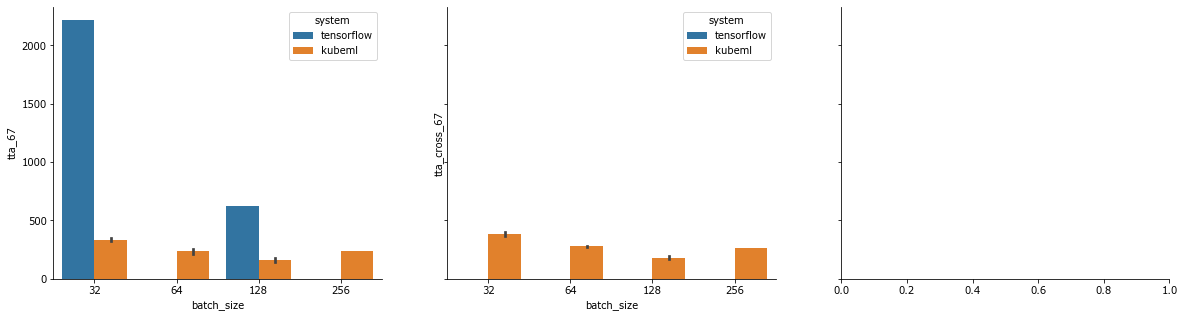

In [63]:
# get only the results with k=-1 and 
_r = r[((r.parallelism==4) | (r.parallelism.isna())) & ((r.k==float('inf')) | (r.k.isna())) ]

f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='tta_67', data=_r, hue='system', ax=ax[0])
sns.barplot(x='batch_size', y='tta_cross_67', data=_r, hue='system', ax=ax[1])
# sns.barplot(x='batch_size', y='gpu_usage', data=df ,ax=ax[2])
sns.despine()

# plt.savefig('./figures/gpu/tta_99.png', dpi=300)

# sns.barplot(x='k', y='tta_99', data=df)

## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [ ]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

res, model = ANOVA(d, y='gpu_usage', verbose=True)

res



### Plot the distributions of time and accuracy as a function of K, Batch and parallelism

#### Plot the accuracy as a factor

In [ ]:
plt.rc('font', size=16)

f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
sns.barplot(x='batch_size', y='acc', hue='k', data=df, ax=ax[0], capsize=.05)
sns.barplot(x='k', y='acc', data=df, ax=ax[1], capsize=.05, hue='parallelism')
sns.barplot(x='parallelism', y='acc', data=df, hue='k' ,ax=ax[2] ,capsize=.05)
sns.despine()
plt.legend(title='k', ncol=4, bbox_to_anchor=(0.075,1))

for a in ax:
    a.set_ylim([75, 100])



# plt.savefig('./figures/resnet34/accuracy.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
plt.figure(figsize=(15,10))
sns.barplot(x='parallelism', y='tta_cross_99', data=df, capsize=.02, hue='batch_size')


# plt.savefig('./figures/resnet34/acc_per_k_and_parallelism.png', dpi=300)

In [ ]:
df= pd.read_pickle('./dataframes/lenet_tensorflow.pkl')
d = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
d = d.loc[d.parallelism==2]

In [ ]:
d.sort_values('tta_cross_99')[['batch_size', 'tta_cross_99']]

#### Plot the time as a factor

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))


sns.barplot(x='batch_size', 
            y='tta_cross_99', 
            data=d ,
            ax=ax[0],
            estimator=np.min)

sns.barplot(x='batch_size', y='tta_cross_99', data=df, ax=ax[1], estimator=np.min)
# sns.barplot(x='parallelism', y='time', data=df, ax=ax[2], hue='k')

# plt.savefig('./figures/resnet34/time.png', dpi=300)

In [ ]:
plt.rc('font', size=16)
f, ax = plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==32], capsize=.05, hue='parallelism', ax=ax[0])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==64], capsize=.05, hue='parallelism', ax=ax[1])
sns.barplot(x='k', y='time', data=df.loc[df.batch_size==128], capsize=.05, hue='parallelism', ax=ax[2])

plt.savefig('./figures/resnet34/time_per_all.png', dpi=300)

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep K and Batch set, vary parallelism

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_k_and_batch(k: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.k==k) & (df.batch_size==batch)].sort_values(by='parallelism', ascending=False)

    plt.rc('font', size=13)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
#             print(row.accuracy)
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.parallelism))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, k={k}')
        ax.legend(title='parallelism')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_k_and_batch(k=8, batch=32, ax=axes[0][0])
plot_loss_with_k_and_batch(k=16, batch=32, ax=axes[0][1])   
plot_loss_with_k_and_batch(k=64, batch=32, ax=axes[0][2])
    
plot_loss_with_k_and_batch(k=8, batch=64, ax=axes[1][0])
plot_loss_with_k_and_batch(k=16, batch=64, ax=axes[1][1])   
plot_loss_with_k_and_batch(k=64, batch=64, ax=axes[1][2])

plot_loss_with_k_and_batch(k=8, batch=128, ax=axes[2][0])
plot_loss_with_k_and_batch(k=16, batch=128, ax=axes[2][1])   
plot_loss_with_k_and_batch(k=64, batch=128, ax=axes[2][2])


# plt.savefig('./figures/accuracy_study.png', dpi=300)


#### Keep Parallelism and batch set, vary K

In [ ]:
# Plot the validation lines of k=-1 and batch = 32 with different parallelism
def plot_loss_with_parallelism_and_batch(p: int, batch:int, ax: plt.Axes = None):
    d = df.loc[(df.parallelism==p) & (df.batch_size==batch)].sort_values(by='k', ascending=False)
    
    approx_k = (60000/p)/batch

    plt.rc('font', size=16)
    if ax is None:
        f = plt.figure(figsize=(10, 5))
        for _, row in d.iterrows():
#             print(row.accuracy)
            plt.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=str(row.k))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy evolution with LeNet (batch={batch}, k={k})')
        plt.legend(title='parallelism', bbox_to_anchor=(1.05, 0.8))
        
    else:
        for _, row in d.iterrows():
            label = str(row.k) if row.k != float('inf') else f'{row.k} ({int(approx_k)})'
            ax.plot(range(1,6), row.accuracy[:-1] if len(row.accuracy) == 6 else row.accuracy, label=label)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Batch={batch}, Parallelism={p}')
        ax.legend(title='k')
        

f, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20), sharex=True)

plt.suptitle('Behavior of K, Parallelism and Batch in Accuracy')

plot_loss_with_parallelism_and_batch(p=2, batch=32, ax=axes[0][0])
plot_loss_with_parallelism_and_batch(p=4, batch=32, ax=axes[0][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=32, ax=axes[0][2])

plot_loss_with_parallelism_and_batch(p=2, batch=64, ax=axes[1][0])
plot_loss_with_parallelism_and_batch(p=4, batch=64, ax=axes[1][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=64, ax=axes[1][2])

plot_loss_with_parallelism_and_batch(p=2, batch=128, ax=axes[2][0])
plot_loss_with_parallelism_and_batch(p=4, batch=128, ax=axes[2][1])   
plot_loss_with_parallelism_and_batch(p=8, batch=128, ax=axes[2][2])


plt.savefig('./figures/accuracy_study_varying_k.png', dpi=300)

#### Plot 3d dependencies between K and parallelism on time and accuracy

In [ ]:
# f, ax = plt.subplots(1, 2, projection='3d')

f = plt.figure()
ax = f.add_subplot(1, 2, 1, projection='3d')

from scipy.interpolate import griddata
X, Y = np.meshgrid(df.k.map(lambda v: 500 if v == float('inf') else v), df.parallelism)
Z = griddata((df.k.map(lambda v: 500 if v == float('inf') else v),
              df.parallelism),
              df.acc, (X, Y), method='cubic')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm',
                       linewidth=0, antialiased=False)


In [ ]:
d = df.loc[df.batch==64]